In [1]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd

sys.path.append(os.path.abspath(".."))

from utils.lstmModel import LstmModel
import utils.lstm as lstm

/home/pbose/tcc/pesquisa/era5/access_era_5.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})


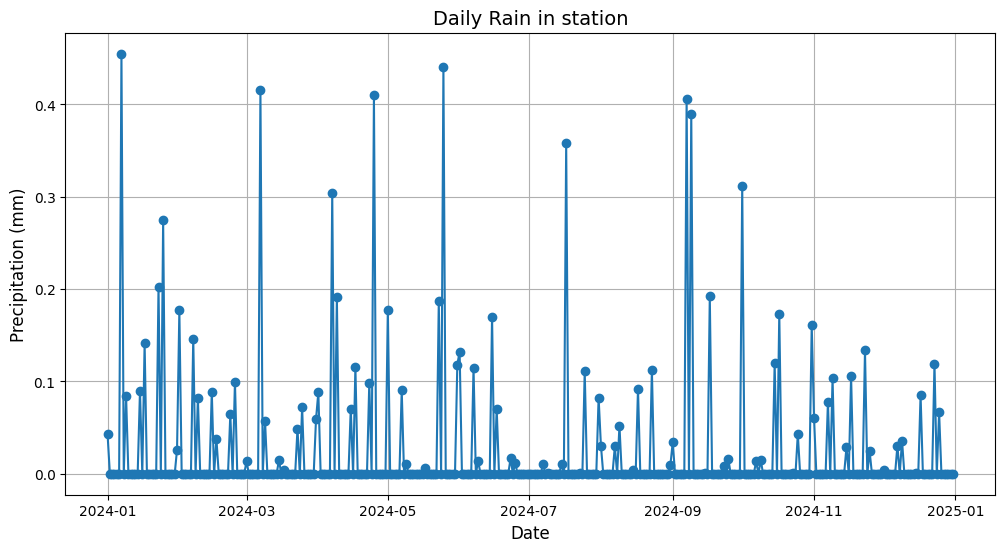

In [2]:
timeseries = access_era_5.recuperar_dados_era_5()
dias = timeseries['valid_time']
total_chuva = timeseries[['tp']].values
train_size = int(len(total_chuva) * 0.60)
test_size = len(total_chuva) - train_size
train, test = total_chuva[:train_size], total_chuva[train_size:]
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()



In [3]:
lookback = 5
X_train, y_train = lstm.create_dataset(train, lookback=lookback)
X_test, y_test = lstm.create_dataset(test, lookback=lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([214, 5, 1]) torch.Size([214, 5, 1])
torch.Size([142, 5, 1]) torch.Size([142, 5, 1])


/home/pbose/tcc/pesquisa/utils/lstm.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  return torch.tensor(X), torch.tensor(y)


In [4]:
model = LstmModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=20)

In [5]:
n_epochs = 5

# --- Loop de Treinamento ---
# Este loop agora foca APENAS em treinar o modelo
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# --- Bloco de Avaliação Final (executado apenas uma vez) ---
print("\nTreinamento finalizado. Calculando o RMSE final...")
model.eval()
with torch.no_grad():
    # Calcula o RMSE para o conjunto de treino
    y_pred_train = model(X_train)
    train_rmse = torch.sqrt(loss_fn(y_pred_train, y_train)).item()
    
    # Calcula o RMSE para o conjunto de teste
    y_pred_test = model(X_test)
    test_rmse = torch.sqrt(loss_fn(y_pred_test, y_test)).item()

print(f"\nRMSE Final de Treino: {train_rmse:.4f}")
print(f"RMSE Final de Teste: {test_rmse:.4f}")


# --- Novo Bloco para Imprimir Previsto vs. Esperado ---
print("\n--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---")
model.eval()
with torch.no_grad():
    # Pega as previsões finais do conjunto de teste
    y_pred_final = model(X_test)
    valores_previstos = y_pred_final.detach().cpu().numpy()
    valores_esperados = y_test.detach().cpu().numpy()

    # Itera sobre os 10 primeiros exemplos e imprime lado a lado
    for i in range(10):
        previsto = valores_previstos[i][0]
        esperado = valores_esperados[i][0]
        print(f"Exemplo {i+1}: Previsto = {previsto}, Esperado = {esperado}")


Treinamento finalizado. Calculando o RMSE final...

RMSE Final de Treino: 0.0774
RMSE Final de Teste: 0.0638

--- Comparando Valores Previstos vs. Esperados (10 primeiros exemplos do teste) ---
Exemplo 1: Previsto = [0.02546134], Esperado = [0.]
Exemplo 2: Previsto = [0.02629147], Esperado = [0.05197525]
Exemplo 3: Previsto = [0.02483188], Esperado = [0.]
Exemplo 4: Previsto = [0.02629147], Esperado = [0.]
Exemplo 5: Previsto = [0.02629147], Esperado = [0.]
Exemplo 6: Previsto = [0.02629147], Esperado = [0.]
Exemplo 7: Previsto = [0.02629147], Esperado = [0.]
Exemplo 8: Previsto = [0.02629147], Esperado = [0.00429153]
Exemplo 9: Previsto = [0.02617098], Esperado = [0.]
Exemplo 10: Previsto = [0.02629147], Esperado = [0.09202957]


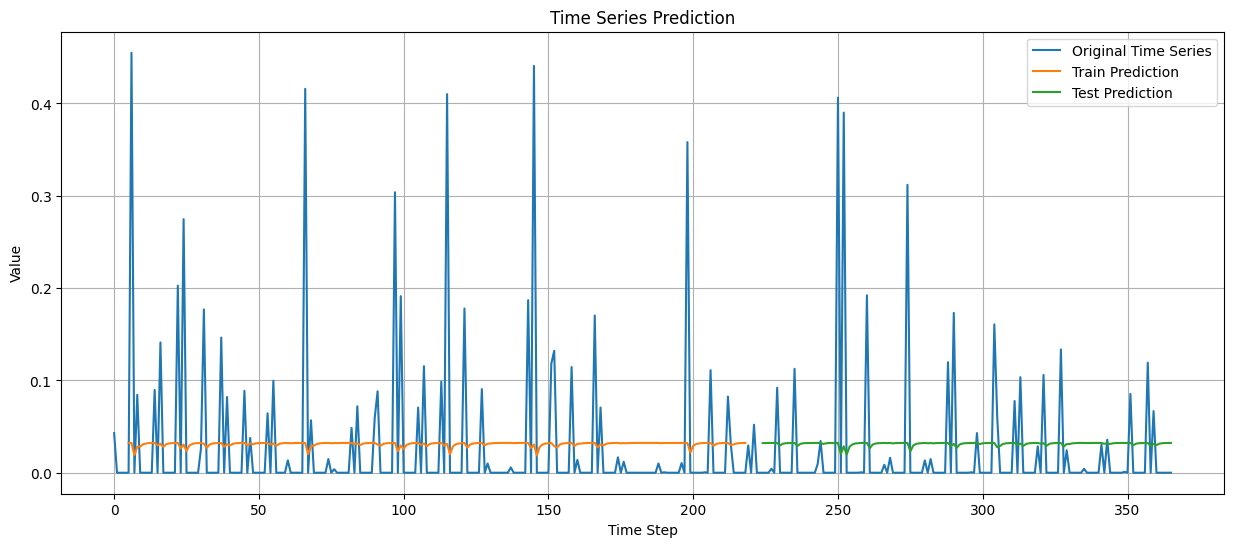

In [8]:
model.eval()
with torch.no_grad():
    # Previsões do modelo
    train_pred = model(X_train)[:, -1, :].squeeze().cpu().numpy()
    test_pred = model(X_test)[:, -1, :].squeeze().cpu().numpy()

# Inicializa arrays com NaN para plotar nas posições corretas
full_len = len(timeseries)
train_plot = np.full(full_len, np.nan)
test_plot = np.full(full_len, np.nan)

# Alinha previsões de treino
train_plot[lookback:lookback + len(train_pred)] = train_pred

# Alinha previsões de teste
test_plot[train_size + lookback : train_size + lookback + len(test_pred)] = test_pred

# Plot
plt.figure(figsize=(15, 6))
plt.plot(total_chuva, label='Original Time Series')
plt.plot(train_plot, label='Train Prediction')
plt.plot(test_plot, label='Test Prediction')
plt.legend()
plt.title('Time Series Prediction')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.grid(True)
plt.show()